In [20]:
"""
- Data Dense
    => eliminate rare fields and values
"""
# importing libs
# nombre de partition (cloisons) par default dans le SC = Le nombre de Workers
import os
import sys
import numpy as np
from time import time
from pyspark import SparkContext
# spark context avec 4 workers

try:
    sc = SparkContext(master="local[4]")
except:
    print('sc already exists : reseting ...')
    sc.stop()
    sc = SparkContext(master="local[4]")
    print('sc reseted successfully')

#import sql context
from pyspark import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
sqlContext = SQLContext(sc)
# dataframes
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, BinaryType


def packArray(a):
    """
    pack a numpy array into a bytearray that can be stored as a single 
    field in a spark DataFrame

    :param a: a numpy ndarray 
    :returns: a bytearray
    :rtype:

    """
    if type(a)!=np.ndarray:
        raise Exception("input to packArray should be numpy.ndarray. It is instead "+str(type(a)))
    return bytearray(a.tobytes())

def unpackArray(x,data_type=np.float16):
    """
    unpack a bytearray into a numpy.ndarray

    :param x: a bytearray
    :param data_type: The dtype of the array. This is important because if determines how many bytes go into each entry in the array.
    :returns: a numpy array
    :rtype: a numpy ndarray of dtype data_type.

    """
    return np.frombuffer(x,dtype=data_type)

def count_nan(V):
    """
    count number of NaN in a bytearray
    
    :param V: a bytearray
    """
    A = unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))

sc already exists : reseting ...
sc reseted successfully


In [4]:
# definition repertoire ou on va mettre les fichiers AWS (dans la VM)
%cd /home/ucsddse230/work/my_code/cours/week1_2/data
!ls


/home/ucsddse230/work/my_code/cours/week1_2/data
mobydick  people2.parquet  people.parquet  Weather


In [5]:
# creation du ss rep Weather s'il n'existe pas, in se place dedans
!mkdir Weather
%cd Weather/

mkdir: cannot create directory ‘Weather’: File exists
/home/ucsddse230/work/my_code/cours/week1_2/data/Weather


In [11]:
# install aws
#!pip install awscli

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 2.4MB 264kB/s eta 0:00:01
    100% |████████████████████████████████| 552kB 1.1MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 5.3MB/s eta 0:00:01
    100% |████████████████████████████████| 5.3MB 106kB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 5.5MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 5.9MB/s eta 0:00:01
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider 

In [ ]:
!aws configure

AWS Access Key ID [None]: 

In [6]:
# check les fichiers présent sur ce noeud
!aws s3 ls s3://dse-weather/ALL.csv.gz

Unable to locate credentials. You can configure credentials by running "aws configure".


In [7]:
#### O nlaisse tomber aws pour le moment on essaie de faire fonctionner ça avec les parquet de l'exercice dataframe_operatiosn
!ls

NY.parquet  NY.tgz


In [21]:
%%time
# import avec Query SQL : on ne prend pas tout le contenu du parquet
weather_parquet_dir = os.getcwd()
print('Directory : ', weather_parquet_dir)

Query = "SELECT measurement, count(measurement) as Count FROM parquet.`%s/NY.parquet` GROUP BY measurement" %(weather_parquet_dir)
print(Query)
counts_pdf = sqlContext.sql(Query).toPandas()
#toPandas() => converts rows to dataframe

counts_pdf.count()

Directory :  /home/ucsddse230/work/my_code/cours/week1_2/data/Weather
SELECT measurement, count(measurement) as Count FROM parquet.`/home/ucsddse230/work/my_code/cours/week1_2/data/Weather/NY.parquet` GROUP BY measurement
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 1.33 s


In [22]:
# Créatiob schema
schema = StructType([StructField("Station",     StringType(), True),
                     StructField("Measurement", StringType(), True),
                     StructField("Year",        IntegerType(),True),
                     StructField("Values",      BinaryType(),True)
                    ])
list(schema)

[StructField(Station,StringType,true),
 StructField(Measurement,StringType,true),
 StructField(Year,IntegerType,true),
 StructField(Values,BinaryType,true)]

In [23]:
%%time
Query2 = "SELECT * FROM parquet.`%s/NY.parquet`" %(weather_parquet_dir)
print(Query2)
DFWeather = sqlContext.sql(Query2)
DFWeather.printSchema()

SELECT * FROM parquet.`/home/ucsddse230/work/my_code/cours/week1_2/data/Weather/NY.parquet`
root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- dist_coast: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 132 ms


In [24]:
DFWeather.select('Values').show(1)

+--------------------+
|              Values|
+--------------------+
|[00 00 00 00 00 0...|
+--------------------+
only showing top 1 row



In [25]:
count_nan_udf = udf(count_nan,IntegerType())
print(type(count_nan_udf))

<class 'function'>


In [33]:
# creation nouvelle colonne au DF avec udf
DFWeather = DFWeather.withColumn('nan_no', count_nan_udf(DFWeather.Values))
DFWeather.printSchema()
type(DFWeather.rdd)

root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- dist_coast: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)
 |-- nan_no: integer (nullable = true)



pyspark.rdd.RDD

In [41]:
# plot histogram using map / reduce
def map_to_hist(n):
    """
    -
    """
    a = np.zeros(366)
    a[n] = 1
    return a
#DFWeather.rdd.take(1)
byMeasurement = DFWeather.rdd.map(lambda row: (row.Measurement,map_to_hist(row.nan_no)))
type(byMeasurement)

pyspark.rdd.PipelinedRDD

In [43]:
%%time
hist = byMeasurement.reduceByKey(lambda x,y:(x+y)).collect()

CPU times: user 20 ms, sys: 20 ms, total: 40 ms
Wall time: 2min 14s


<class 'list'>


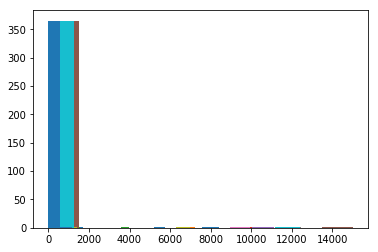

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
print(type(hist))
#print(hist[0])
#plt.hist((hist[0][1]))

df_hist = pd.DataFrame(hist, columns=['Measurement', 'frequency'])
for i in range(df_hist['Measurement'].count()-1):
    plt.hist(df_hist['frequency'][i])